In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import trimesh

scene = trimesh.Scene()

In [2]:
import my_code.diffusion_training.data_loading as data_loading

train_dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'train', 32, canonicalize_fmap='sum'
    )[1]
test_dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'test', 32, canonicalize_fmap='sum'
)[1]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading base dataset: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.26it/s]


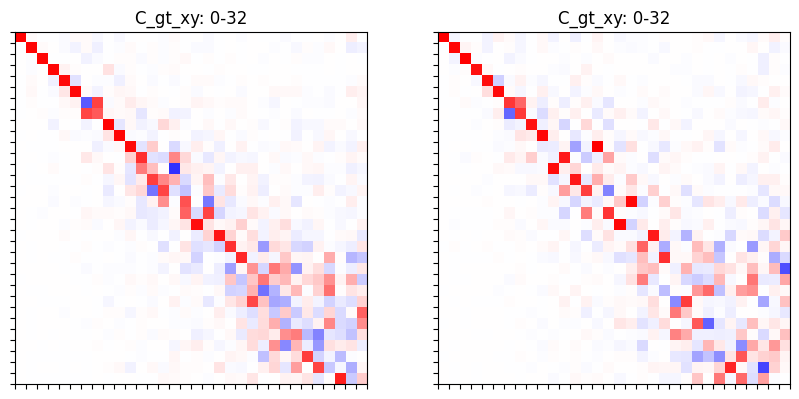

In [3]:
import my_code.plotting_utils as plotting_utils

l = 0
h = 32

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotting_utils.plot_Cxy(fig, axs[0], train_dataset[78]['second']['C_gt_xy'][0],
                        'C_gt_xy', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], test_dataset[1]['second']['C_gt_xy'][0],
                        'C_gt_xy', l, h, show_grid=False, show_colorbar=False)

plt.show()

In [4]:
def predict_sign_change(net, verts, faces, evecs_flip, evecs_cond):
    
    # normalize the evecs
    evecs_flip = torch.nn.functional.normalize(evecs_flip, p=2, dim=1)
    
    if evecs_cond is not None:
        evecs_cond = torch.nn.functional.normalize(evecs_cond, p=2, dim=1)
        evecs_input = torch.cat([evecs_flip, evecs_cond], dim=-1)
    else:
        evecs_input = evecs_flip
        
    # process the flipped evecs
    support_vector_flip = net(
        verts=verts,
        faces=faces,
        feats=evecs_input,
    ) # [1 x 6890 x 1]

    # normalize the support vector
    support_vector_norm = torch.nn.functional.normalize(support_vector_flip, p=2, dim=1)
    
    # multiply the support vector by the flipped evecs [1 x 6890 x 4].T @ [1 x 6890 x 4]
    product_with_support = support_vector_norm.transpose(1, 2) @ evecs_flip

    if product_with_support.shape[1] == product_with_support.shape[2]:
        # take only diagonal elements
        product_with_support = torch.diagonal(product_with_support, dim1=1, dim2=2)
        
    # get the sign of the support vector
    sign_flip_predicted = product_with_support
 
    return sign_flip_predicted, support_vector_norm

In [5]:
import networks.diffusion_network as diffusion_network

condition_dim = 0
start_dim = 0
feature_dim = 32


device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = diffusion_network.DiffusionNet(
    in_channels=feature_dim + condition_dim,
    out_channels=feature_dim,
    # hidden_channels=feature_dim // 2,
    cache_dir=f'data_with_smpl_corr/FAUST_original/{200}',
    input_type='wks',
    ).to(device)

opt = torch.optim.Adam(net.parameters(), lr=1e-3)


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd


loss_fn = torch.nn.MSELoss()
losses = torch.tensor([])
iterator = tqdm(range(30001))

possible_shapes = [train_dataset[i]['second'] for i in range(len(train_dataset))]
# possible_shapes = [train_dataset[i]['second'] for i in range(2)]
                   
for i in iterator:

    ##############################################
    # Select a shape
    ##############################################
    curr_idx = np.random.randint(0, len(possible_shapes))
    
    train_shape = possible_shapes[curr_idx]

    verts = train_shape['verts'].unsqueeze(0).to(device)
    faces = train_shape['faces'].unsqueeze(0).to(device)

    evecs_orig = train_shape['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)

    # evecs_cond = None
    evecs_cond = train_shape['evecs'][:,
        start_dim + feature_dim : start_dim + feature_dim + condition_dim].unsqueeze(0).to(device)

    ##############################################
    # Set the signs
    ##############################################

    # create a random combilation of +1 and -1, length = feature_dim
    sign_flip_gt = torch.randint(0, 2, (feature_dim,)).float().to(device)
    
    sign_flip_gt[sign_flip_gt == 0] = -1
    sign_flip_gt = sign_flip_gt.float().unsqueeze(0)

    # multiply evecs [6890 x 16] by sign_flip [16]
    evecs_flip = evecs_orig * sign_flip_gt
    
    
    ##############################################
    # predict the sign change
    ##############################################
    
    sign_change_flipped = predict_sign_change(net, verts, faces, evecs_flip, 
                                              evecs_cond=evecs_cond)[0]
    
    # calculate the loss
    loss = loss_fn(
        sign_change_flipped.reshape(sign_change_flipped.shape[0], -1),
        sign_flip_gt.reshape(sign_flip_gt.shape[0], -1)
        )

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses = torch.cat([losses, torch.tensor([loss.item()])])
    
    # print mean of last 10 losses
    iterator.set_description(f'loss={torch.mean(losses[-10:]):.3f}')
    
    # plot the losses every 1000 iterations
    if i > 0 and i % (len(iterator) // 10) == 0:
        pd.Series(losses.numpy()).rolling(10).mean().plot()
        plt.yscale('log')
        plt.show()


In [7]:
test_shapes_list = [test_dataset[i]['second'] for i in range(len(test_dataset))]
                   
iterator = tqdm(range(1001))

incorrect_signs_list = torch.tensor([])
for i in iterator:

    ##############################################
    # Select a shape
    ##############################################
    # test_shape = test_shapes_list[i]
    
    curr_idx = np.random.randint(0, len(test_shapes_list))   
    test_shape = test_shapes_list[curr_idx]    

    verts = test_shape['verts'].unsqueeze(0).to(device)
    faces = test_shape['faces'].unsqueeze(0).to(device)

    evecs_orig = test_shape['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)
    evecs_cond = test_shape['evecs'][:,
        start_dim + feature_dim : start_dim + feature_dim + condition_dim].unsqueeze(0).to(device)


    ##############################################
    # Set the signs
    ##############################################

    # create a random combilation of +1 and -1, length = feature_dim
    sign_flip_gt = torch.randint(0, 2, (feature_dim,)).float().to(device)
    
    sign_flip_gt[sign_flip_gt == 0] = -1
    sign_flip_gt = sign_flip_gt.float().unsqueeze(0)

    # multiply evecs [6890 x 16] by sign_flip [16]
    evecs_flip = evecs_orig * sign_flip_gt
    
    
    ##############################################
    # predict the sign change
    ##############################################
    
    with torch.no_grad():
        sign_flip_predicted, support_vector_norm = predict_sign_change(
            net, verts, faces, evecs_flip, evecs_cond=evecs_cond)

    sign_correct = sign_flip_predicted.sign() * sign_flip_gt.sign()
    
    # count the number of incorrect signs
    count_incorrect_signs = (sign_correct < 0).int().sum()
    # incorrect_signs_list.append(count_incorrect_signs)
    incorrect_signs_list = torch.cat([incorrect_signs_list, torch.tensor([count_incorrect_signs])])
    
    
    iterator.set_description(f'Mean incorrect signs {incorrect_signs_list.float().mean():.2f} / {feature_dim}')
    
    
print(f'Results for {len(incorrect_signs_list)} test shapes')
print(f'Incorrect signs per shape: {incorrect_signs_list.float().mean():.2f} / {feature_dim}')

# print('Shape idx', curr_idx)
print('GT', sign_flip_gt)
print('PRED', sign_flip_predicted)
print('Correct', sign_correct)
print(f'Incorrect signs {torch.sum(sign_correct != 1)} / {feature_dim}')

# plt.plot(support_vector_norm.squeeze().detach().cpu().numpy(), '.', alpha=0.1)
# plt.ylim(-0.1, 0.1)
# # plt.yscale('log')
# plt.show()


Mean incorrect signs 2.66 / 32: 100%|█████████████████████████████████████████████████████████████| 1001/1001 [00:25<00:00, 39.37it/s]


Results for 1001 test shapes
Incorrect signs per shape: 2.66 / 32
GT tensor([[ 1., -1., -1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
         -1.,  1.,  1., -1., -1., -1.,  1., -1.,  1., -1., -1., -1., -1.,  1.,
          1.,  1., -1.,  1.]], device='cuda:0')
PRED tensor([[ 1.0000, -0.9523, -0.8528, -0.8812,  0.9103, -0.8903, -0.7653, -0.6574,
          0.7894,  0.8483,  0.3924,  0.6661,  0.6903,  0.1535, -0.6986,  0.5225,
          0.4972, -0.7008, -0.6915, -0.2381, -0.0638, -0.2035,  0.4871, -0.1822,
         -0.1582, -0.3300, -0.1937, -0.2357, -0.0747,  0.1837, -0.0361,  0.4951]],
       device='cuda:0')
Correct tensor([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
         -1.,  1.,  1.,  1.]], device='cuda:0')
Incorrect signs 3 / 32


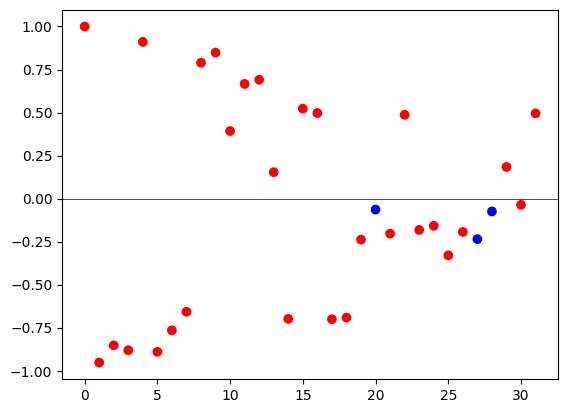

In [8]:
# plt.plot(sign_flip_gt.squeeze().detach().cpu().numpy(), '.')

# marker color = blue if incorrect, red if correct

color = np.where(sign_correct.squeeze().detach().cpu().numpy() == 1, 'red', 'blue')

plt.scatter(np.arange(feature_dim), sign_flip_predicted.squeeze().detach().cpu().numpy(), c=color)

plt.axhline(0, color='black', linewidth=0.5)
# plt.plot(sign_correct.squeeze().detach().cpu().numpy(), '.')

In [9]:
incorrect_signs_list[:20]

tensor([2., 3., 7., 2., 5., 1., 3., 3., 6., 2., 6., 6., 6., 5., 3., 5., 3., 2.,
        7., 2.])

In [11]:
evecs_flip.shape

torch.Size([1, 6890, 32])

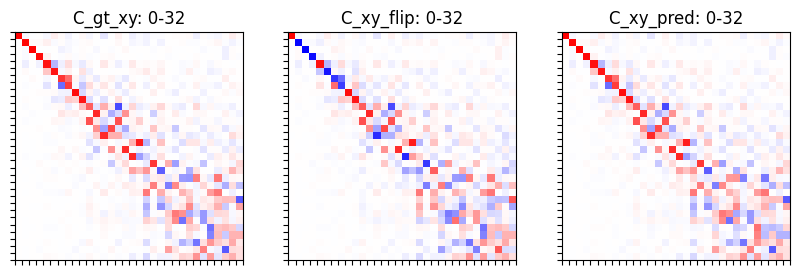

In [9]:
# evecs_orig, evecs_flip
# sign_flip_gt, sign_flip_predicted

# evecs_orig, evecs_flip * sign_flip_gt

C_gt_xy = test_shape['C_gt_xy'][0]
corr_second = test_shape['corr']
corr_first = train_dataset[0]['first']['corr']
evecs_first = train_dataset[0]['first']['evecs']


C_xy_flip = torch.linalg.lstsq(
    evecs_flip.cpu()[0, corr_second],
    evecs_first[corr_first]
    ).solution
C_xy_pred = torch.linalg.lstsq(
    evecs_flip.cpu()[0, corr_second] * torch.sign(sign_flip_predicted).cpu(),
    evecs_first[corr_first]
    ).solution


l = 0
h = 32


fig, axs = plt.subplots(1, 3, figsize=(10, 5))

plotting_utils.plot_Cxy(fig, axs[0], C_gt_xy, 'C_gt_xy', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], C_xy_flip, 'C_xy_flip', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], C_xy_pred, 'C_xy_pred', l, h, show_grid=False, show_colorbar=False)

plt.show()